### Multi-Label Classification with an Enzyme Substrate Dataset


**Goal**: The goal of this project is to build machine learning models that can accurately predict the enzyme classification of proteins under the first two Enzyme Commission categories (EC1 and EC2) using the six provided input features. By focusing on these two categories, the project aims to demonstrate how computational methods can assist in functional annotation of enzymes, reducing the time and cost of manual biochemical experiments.

In [1]:
#loaded the necessasy libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load the training dataset
train = pd.read_csv('train.csv')
train.head()

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2,EC3,EC4,EC5,EC6
0,0,323.390782,9.879918,5.875576,5.875576,4.304757,4.304757,2.754513,1.749203,0.000000,...,4.794537,35.527357,0,0,1,1,0,0,0,0
1,1,273.723798,7.259037,4.441467,5.834958,3.285046,4.485235,2.201375,1.289775,45.135471,...,13.825658,44.707310,0,0,0,1,1,0,0,0
2,2,521.643822,10.911303,8.527859,11.050864,6.665291,9.519706,5.824822,1.770579,15.645394,...,17.964475,45.660120,0,0,1,1,0,0,1,0
3,3,567.431166,12.453343,7.089119,12.833709,6.478023,10.978151,7.914542,3.067181,95.639554,...,31.961948,87.509997,0,0,1,1,0,0,0,0
4,4,112.770735,4.414719,2.866236,2.866236,1.875634,1.875634,1.036450,0.727664,17.980451,...,9.589074,33.333333,2,2,1,0,1,1,1,0


#### Dataset Description

The dataset used in this project is from the **Multi-Label Classification of Enzyme Substrates** competition. It consists of molecular descriptors and targets for enzyme classification. The goal of this project is to predict **EC1** and **EC2** using these features.

##### Columns

**Features (X):**

- `BertzCT` : Molecular complexity descriptor based on graph theory.  
- `Chi1`, `Chi1n`, `Chi1v`, `Chi2n`, `Chi2v`, `Chi3v`, `Chi4n` : Molecular connectivity indices (Chi descriptors).  
- `EState_VSA1`, `EState_VSA2` : Electrotopological state descriptors combined with van der Waals surface area.  
- `ExactMolWt` : Exact molecular weight of the compound.  
- `FpDensityMorgan1`, `FpDensityMorgan2`, `FpDensityMorgan3` : Morgan fingerprint densities (topological descriptors).  
- `HallKierAlpha` : Molecular shape index descriptor.  
- `HeavyAtomMolWt` : Molecular weight considering only heavy atoms.  
- `Kappa3` : Molecular shape index (third order).  
- `MaxAbsEStateIndex`, `MinEStateIndex` : Maximum and minimum electrotopological state indices.  
- `NumHeteroatoms` : Number of heteroatoms in the molecule.  
- `PEOE_VSA6`, `PEOE_VSA7`, `PEOE_VSA8`, `PEOE_VSA10`, `PEOE_VSA14` : Partial charge descriptors combined with van der Waals surface area.  
- `SMR_VSA5`, `SMR_VSA10` : Molar refractivity descriptors combined with van der Waals surface area.  
- `SlogP_VSA3` : Lipophilicity (LogP) combined with van der Waals surface area.  
- `VSA_EState9` : Electrotopological state descriptor combined with van der Waals surface area.  
- `fr_COO`, `fr_COO2` : Count of specific functional groups (carboxylic acids).  

**Targets (y):**

- `EC1` : First level enzyme classification (binary).  
- `EC2` : Second level enzyme classification (binary).  
- `EC3`–`EC6` : Additional enzyme classification levels (binary, not used in this project).  
  



In [3]:
#loading the test dataset
test = pd.read_csv('test.csv')
test.head()

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2
0,14838,344.632371,7.283603,4.473966,5.834958,3.412257,4.651530,2.096558,1.116433,49.458581,...,13.512441,0.000000,0.000000,0.000000,26.809272,24.539800,4.794537,47.304082,1,1
1,14839,1432.410201,10.663869,7.079026,8.065215,5.297097,5.297097,3.924155,2.569694,0.000000,...,0.000000,34.947374,98.323987,9.606882,0.000000,53.378235,0.000000,43.166667,0,0
2,14840,83.352608,3.931852,1.774215,1.774215,1.073446,1.073446,0.467830,0.170838,5.969305,...,5.969305,0.000000,0.000000,6.420822,11.752550,13.344559,9.589074,24.666667,1,1
3,14841,150.255712,5.912790,3.548812,3.548812,2.595128,2.595128,1.642813,0.694113,0.000000,...,59.935299,0.000000,0.000000,0.000000,17.744066,32.290168,4.794537,26.778866,0,0
4,14842,1817.276351,24.910940,15.540529,20.047314,12.535886,17.730988,11.979618,4.431173,84.554972,...,23.468091,25.609359,0.000000,37.099000,69.141353,38.704130,50.697492,102.583333,0,0


<b>Data Understanding</b>

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14838 entries, 0 to 14837
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 14838 non-null  int64  
 1   BertzCT            14838 non-null  float64
 2   Chi1               14838 non-null  float64
 3   Chi1n              14838 non-null  float64
 4   Chi1v              14838 non-null  float64
 5   Chi2n              14838 non-null  float64
 6   Chi2v              14838 non-null  float64
 7   Chi3v              14838 non-null  float64
 8   Chi4n              14838 non-null  float64
 9   EState_VSA1        14838 non-null  float64
 10  EState_VSA2        14838 non-null  float64
 11  ExactMolWt         14838 non-null  float64
 12  FpDensityMorgan1   14838 non-null  float64
 13  FpDensityMorgan2   14838 non-null  float64
 14  FpDensityMorgan3   14838 non-null  float64
 15  HallKierAlpha      14838 non-null  float64
 16  HeavyAtomMolWt     148

In [5]:
train.describe()

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2,EC3,EC4,EC5,EC6
count,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,...,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000
mean,7418.500000,515.153604,9.135189,5.854307,6.738497,4.432570,5.253221,3.418749,1.773472,29.202823,...,13.636941,49.309959,0.458215,0.459226,0.667745,0.798962,0.313789,0.279081,0.144831,0.151570
std,4283.505982,542.456370,6.819989,4.647064,5.866444,3.760516,4.925065,3.436208,1.865898,31.728679,...,14.598554,29.174824,0.667948,0.668111,0.471038,0.400790,0.464047,0.448562,0.351942,0.358616
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-5.430556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3709.250000,149.103601,4.680739,2.844556,2.932842,1.949719,2.034468,1.160763,0.503897,5.969305,...,4.794537,30.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,7418.500000,290.987941,6.485270,4.052701,4.392859,2.970427,3.242775,1.948613,1.073261,17.353601,...,9.589074,41.666667,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,11127.750000,652.652585,11.170477,7.486791,8.527859,5.788793,6.609350,4.502070,2.534281,44.876559,...,14.912664,56.090650,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,14837.000000,4069.959780,69.551167,50.174588,53.431954,32.195368,34.579313,22.880836,16.072810,363.705954,...,115.406157,384.450519,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
#check for nulls on the training set
train.isnull().sum()

id                   0
BertzCT              0
Chi1                 0
Chi1n                0
Chi1v                0
Chi2n                0
Chi2v                0
Chi3v                0
Chi4n                0
EState_VSA1          0
EState_VSA2          0
ExactMolWt           0
FpDensityMorgan1     0
FpDensityMorgan2     0
FpDensityMorgan3     0
HallKierAlpha        0
HeavyAtomMolWt       0
Kappa3               0
MaxAbsEStateIndex    0
MinEStateIndex       0
NumHeteroatoms       0
PEOE_VSA10           0
PEOE_VSA14           0
PEOE_VSA6            0
PEOE_VSA7            0
PEOE_VSA8            0
SMR_VSA10            0
SMR_VSA5             0
SlogP_VSA3           0
VSA_EState9          0
fr_COO               0
fr_COO2              0
EC1                  0
EC2                  0
EC3                  0
EC4                  0
EC5                  0
EC6                  0
dtype: int64

There were no nulls on the training data set

In [7]:
#checking for the nulls in the test set
test.isnull().sum()

id                   0
BertzCT              0
Chi1                 0
Chi1n                0
Chi1v                0
Chi2n                0
Chi2v                0
Chi3v                0
Chi4n                0
EState_VSA1          0
EState_VSA2          0
ExactMolWt           0
FpDensityMorgan1     0
FpDensityMorgan2     0
FpDensityMorgan3     0
HallKierAlpha        0
HeavyAtomMolWt       0
Kappa3               0
MaxAbsEStateIndex    0
MinEStateIndex       0
NumHeteroatoms       0
PEOE_VSA10           0
PEOE_VSA14           0
PEOE_VSA6            0
PEOE_VSA7            0
PEOE_VSA8            0
SMR_VSA10            0
SMR_VSA5             0
SlogP_VSA3           0
VSA_EState9          0
fr_COO               0
fr_COO2              0
dtype: int64

There were no nulls on the test set

<b>Explanatory Data Analysis</b>

Target (EC Classes) Distribution

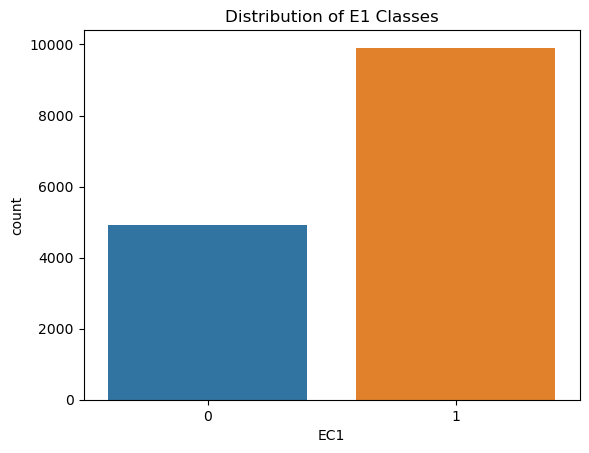

In [8]:
#target (E1 Classes) distribution
sns.countplot(x='EC1', data=train)
plt.title('Distribution of E1 Classes') 
plt.show()

##### Insights from the graph
- There are significantly more samples labeled as class 1 than class 0.
- This indicates a class imbalance: class 1 is almost twice as frequent as class 0.

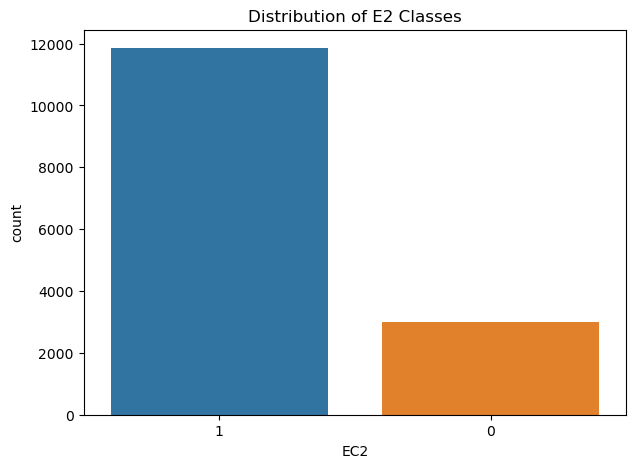

In [9]:
#target (E2 Classes) distribution
plt.figure(figsize=(7, 5))
sns.countplot(x='EC2', data=train, order=train['EC2'].value_counts().index)
plt.title('Distribution of E2 Classes') 
plt.show()

##### Insights from the graph
- There are significantly more samples labeled as class 1 than class 0 for the EC2, this indicates a class imbalance: class 1 is almost twice as frequent as class 0.

Correlation between features

In [10]:
corr_matrix = train.corr()
print(corr_matrix['EC1'].sort_values(ascending=False))
print(corr_matrix['EC2'].sort_values(ascending=False))

EC1                  1.000000
MinEStateIndex       0.208827
PEOE_VSA6            0.084942
PEOE_VSA7            0.083718
PEOE_VSA8            0.052619
EState_VSA2          0.040751
fr_COO2              0.014989
fr_COO               0.014353
id                   0.010901
Kappa3               0.002552
FpDensityMorgan1     0.000125
FpDensityMorgan2    -0.002198
FpDensityMorgan3    -0.005985
HallKierAlpha       -0.020765
SMR_VSA10           -0.025373
Chi4n               -0.054333
Chi1n               -0.055030
Chi2n               -0.056264
SMR_VSA5            -0.056336
BertzCT             -0.060120
Chi3v               -0.061797
EC6                 -0.063344
Chi2v               -0.064649
Chi1v               -0.065679
Chi1                -0.069660
ExactMolWt          -0.075954
HeavyAtomMolWt      -0.078682
EC4                 -0.091273
VSA_EState9         -0.093636
SlogP_VSA3          -0.109439
EC5                 -0.112205
PEOE_VSA10          -0.115469
MaxAbsEStateIndex   -0.122893
PEOE_VSA14

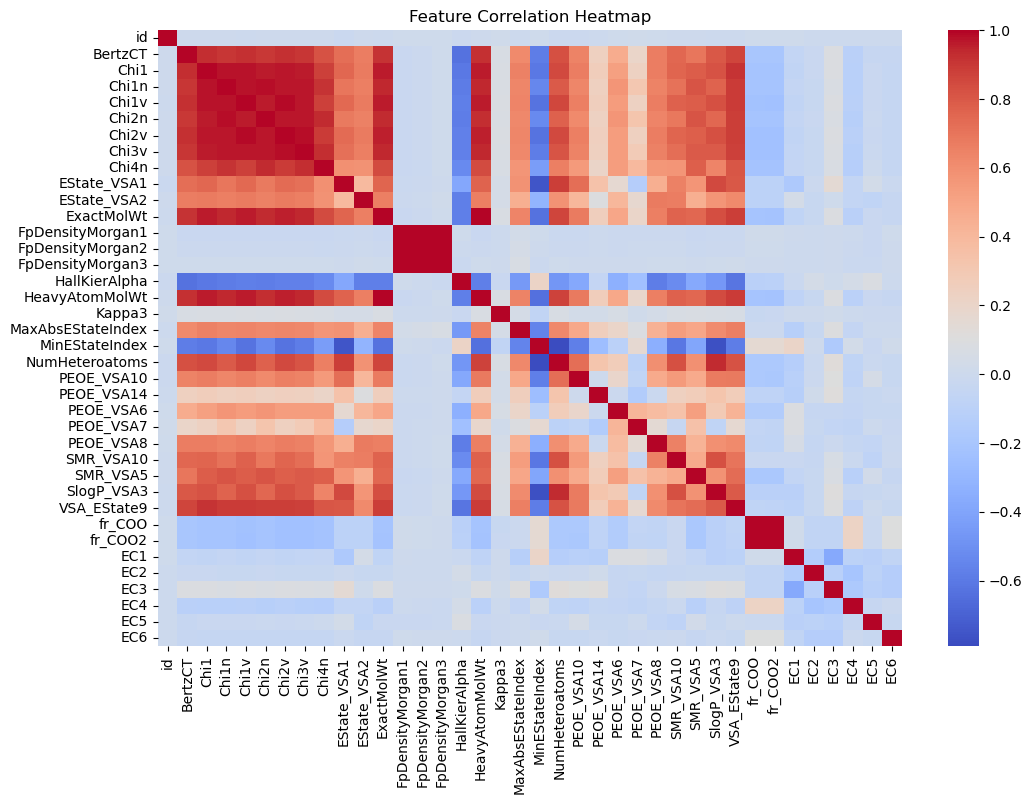

In [11]:
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(), cmap="coolwarm", annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

From the above, there are no strong direct relationships between individual features and EC1/EC2, but predictive models may still perform well by leveraging multiple features and their interactions.

Feature Distribution

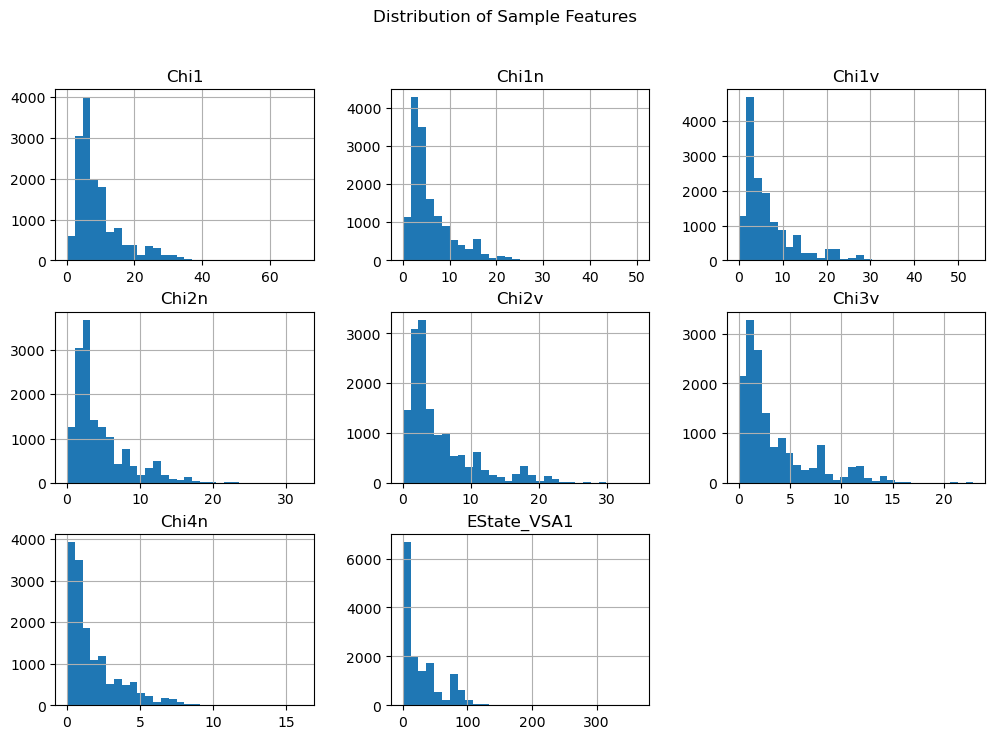

In [12]:
# histogram for first few numeric features
train.iloc[:, 2:10].hist(figsize=(12,8), bins=30)
plt.suptitle("Distribution of Sample Features")
plt.show()


From the above graph, most features are right-skewed. Also, the ranges and distribution vary widely from the graphs so then to solve this would be by scaling the data.

In [13]:
print(train['EC1'].value_counts(normalize=True))

print(train['EC2'].value_counts(normalize=True))


EC1
1    0.667745
0    0.332255
Name: proportion, dtype: float64
EC2
1    0.798962
0    0.201038
Name: proportion, dtype: float64


<b>Modelling</b>

Train-test split

In [14]:
X = train.drop(['EC1','EC2','EC3','EC4','EC5','EC6'], axis=1)
y1 = train['EC1'] # Target variable for EC1 classification
y2 = train['EC2'] # Target variable for EC2 classification


In [15]:
def run_models(X, y, test_size=0.2, random_state=42):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print("Class distribution in training data:\n", y_train.value_counts())
    print("\n")
    
    # Logistic Regression
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_train, y_train)
    y_pred_lr = logreg.predict(X_test)
    print("=== Logistic Regression ===")
    print("Accuracy:", accuracy_score(y_test, y_pred_lr))
    print(classification_report(y_test, y_pred_lr))
    
    # Random Forest
    rf = RandomForestClassifier(n_estimators=120,random_state=random_state)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    print("=== Random Forest ===")
    print("Accuracy:", accuracy_score(y_test, y_pred_rf))
    print(classification_report(y_test, y_pred_rf))

    #xboost
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    print("=== XGBoost Classifier ===")
    print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
    print(classification_report(y_test, y_pred_xgb))

    
    return logreg, rf, xgb

# EC1
log_model1, rf_model1, xgb_model1 = run_models(X, y1)

# EC2
log_model2, rf_model2, xgb_model2 = run_models(X, y2)


Class distribution in training data:
 EC1
1    7916
0    3954
Name: count, dtype: int64


=== Logistic Regression ===
Accuracy: 0.6896900269541779
              precision    recall  f1-score   support

           0       0.57      0.23      0.33       976
           1       0.71      0.91      0.80      1992

    accuracy                           0.69      2968
   macro avg       0.64      0.57      0.56      2968
weighted avg       0.66      0.69      0.64      2968

=== Random Forest ===
Accuracy: 0.6923854447439353
              precision    recall  f1-score   support

           0       0.55      0.35      0.43       976
           1       0.73      0.86      0.79      1992

    accuracy                           0.69      2968
   macro avg       0.64      0.61      0.61      2968
weighted avg       0.67      0.69      0.67      2968

=== XGBoost Classifier ===
Accuracy: 0.6782345013477089
              precision    recall  f1-score   support

           0       0.52      0.36    

The models (Logistic Regression, Random Forest, and XGBoost) achieved moderate accuracy for EC1 (~68–69%) and higher accuracy for EC2 (~78–81%). However, accuracy alone was misleading due to severe class imbalance. For EC1, all three models showed much stronger performance on class 1 compared to class 0, with the minority class having weak recall and F1-scores. Similarly, for EC2, the models almost completely ignored class 0, predicting class 1 in nearly all cases. This bias indicates that the models are overfitting to the majority class, leading to poor generalization for minority categories. These results emphasize the importance of handling imbalance (e.g., with SMOTE) to build fairer and more reliable classifiers.

In [16]:
def run_models(X, y, test_size=0.2, random_state=42):
    """
    Trains Logistic Regression and Random Forest on the dataset with scaling + SMOTE,
    then prints classification reports and accuracy scores.
    Returns the trained models and the scaler.
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Scale features 
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply SMOTE to the scaled training data
    sm = SMOTE(random_state=random_state)
    X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)
    
    print("Before SMOTE class distribution:\n", y_train.value_counts())
    print("After SMOTE class distribution:\n", y_resampled.value_counts())
    print("\n")
    
    # Logistic Regression
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_resampled, y_resampled)
    y_pred_lr = logreg.predict(X_test_scaled)
    print("=== Logistic Regression ===")
    print("Accuracy:", accuracy_score(y_test, y_pred_lr))
    print(classification_report(y_test, y_pred_lr))
    
    # Random Forest
    rf = RandomForestClassifier(n_estimators=120, random_state=random_state)
    rf.fit(X_resampled, y_resampled)
    y_pred_rf = rf.predict(X_test_scaled)
    print("=== Random Forest ===")
    print("Accuracy:", accuracy_score(y_test, y_pred_rf))
    print(classification_report(y_test, y_pred_rf))

    xgb = XGBClassifier()
    xgb.fit(X_resampled, y_resampled)
    y_pred_xgb = xgb.predict(X_test_scaled)
    print("=== XGBoost Classifier ===")
    print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
    print(classification_report(y_test, y_pred_xgb))
    
    return logreg, rf, xgb, scaler

# EC1
log_model1, rf_model1,xgb_model1, scaler = run_models(X, y1)

# EC2
log_model2, rf_model2, xgb_model1, scaler = run_models(X, y2)


Before SMOTE class distribution:
 EC1
1    7916
0    3954
Name: count, dtype: int64
After SMOTE class distribution:
 EC1
1    7916
0    7916
Name: count, dtype: int64


=== Logistic Regression ===
Accuracy: 0.6704851752021563
              precision    recall  f1-score   support

           0       0.50      0.60      0.55       976
           1       0.78      0.70      0.74      1992

    accuracy                           0.67      2968
   macro avg       0.64      0.65      0.64      2968
weighted avg       0.69      0.67      0.68      2968

=== Random Forest ===
Accuracy: 0.6890161725067385
              precision    recall  f1-score   support

           0       0.53      0.49      0.51       976
           1       0.76      0.78      0.77      1992

    accuracy                           0.69      2968
   macro avg       0.64      0.64      0.64      2968
weighted avg       0.68      0.69      0.69      2968

=== XGBoost Classifier ===
Accuracy: 0.6745283018867925
             

For EC1, balancing the classes improved fairness between majority and minority predictions.

Logistic Regression achieved 67% accuracy, with recall balanced across both classes (0.60 for class 0, 0.70 for class 1).

Random Forest performed slightly better (69% accuracy), with class 0 recall improving to 0.49 compared to pre-SMOTE.

XGBoost gave 67% accuracy, maintaining high recall for class 1 (0.79) while improving class 0 performance.

Overall, SMOTE reduced bias toward class 1 and allowed all models to recognize class 0 better, though accuracy stayed around 67–69%.

For EC2, results were more mixed.

Logistic Regression struggled (56% accuracy), showing unstable performance despite balancing.

Random Forest achieved the best results (79% accuracy) with strong performance on class 1 (0.95 recall) but weak detection of class 0 (0.08 recall).

XGBoost performed comparably (76% accuracy) with similar trends—excellent recall for class 1 (0.92) but poor recall for class 0 (0.10).

In [ ]:
# Use the same features as training
X_test_final = test[X.columns]  

# Scale with the same scaler
X_test_final_scaled = scaler.transform(X_test_final)

# Predict PROBABILITIES for EC1 and EC2 (Random Forest)
test_probs_ec1 = rf_model1.predict_proba(X_test_final_scaled)[:, 1]  
test_probs_ec2 = rf_model2.predict_proba(X_test_final_scaled)[:, 1]  

predictions = pd.DataFrame({
    "id": test["id"],   
    "EC1": test_probs_ec1,
    "EC2": test_probs_ec2
})

In [18]:
predictions.head()

,id,EC1,EC2
0,14838,0.458333,0.600000
1,14839,0.750000,0.691667
2,14840,0.725000,0.608333
3,14841,0.741667,0.691667
4,14842,0.833333,0.766667
